In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it
    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [ ]:
# Define the function to return the SMAPE value
def smape(actual, predicted):
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

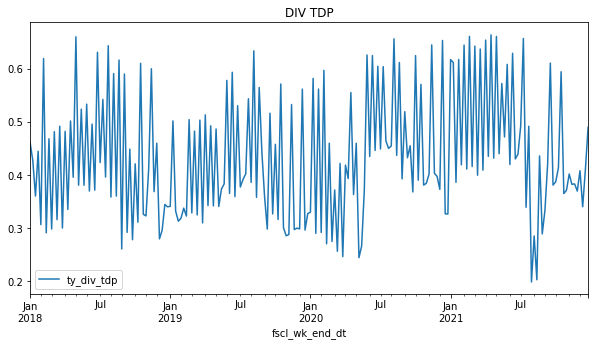

In [ ]:
df = pd.read_csv("result_CA4000431_000000681000011800.csv")
df.columns = [c.lower() for c in df.columns]
df.fscl_wk_end_dt = pd.to_datetime(df['fscl_wk_end_dt'])
df.index = pd.to_datetime(df['fscl_wk_end_dt'], format='%Y-%m.%d')
orig_df = df.copy()

df = df[['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]

df = df[['ty_div_tdp']]
df = df.astype(float)

df.plot(figsize=(10,5),title="DIV TDP")


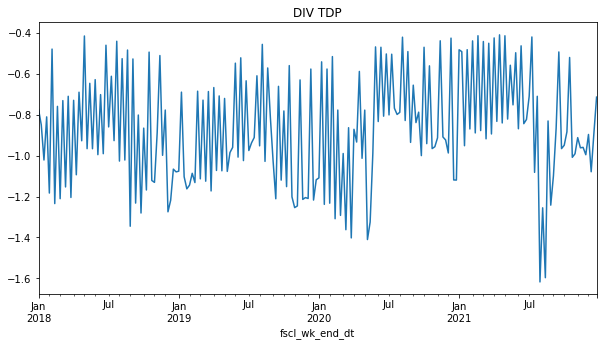

In [ ]:
np.log(df['ty_div_tdp']).plot(figsize=(10,5),title="DIV TDP")

In [ ]:
df_try_1 = orig_df[['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]
df_try_1['ty_div_tdp_52weeks_ago'] = df_try_1[['ty_div_tdp']].shift(52)
df_try_1['khc_fscl_yr_wk_val_52wks_ago'] = df_try_1[['khc_fscl_yr_wk_val']].shift(52)
df_try_1 = df_try_1.fillna(0)
df_try_1['khc_fscl_yr_wk_val_52wks_ago'] =df_try_1['khc_fscl_yr_wk_val_52wks_ago'].astype(int)

df_try_2 = df_try_1[(df_try_1.khc_fscl_yr_wk_val >= 202012) & (df_try_1.khc_fscl_yr_wk_val <= 202111)]
df_try_2 = df_try_2[['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp_52weeks_ago']]
df_try_2.columns = ['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']
final_df_1 = pd.concat([df_try_1[df_try_1.khc_fscl_yr_wk_val < 202012][['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]
                    , df_try_2[['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]
                    , df_try_1[df_try_1.khc_fscl_yr_wk_val > 202012][['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]
                    ])
final_df_1 = final_df_1[['ty_div_tdp']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
final_df_1

,ty_div_tdp
fscl_wk_end_dt,
2018-01-06,0.460651
2018-01-13,0.427280
2018-01-20,0.359968
2018-01-27,0.444367
2018-02-03,0.306313
...,...
2021-11-27,0.369375
2021-12-04,0.407805
2021-12-11,0.339899


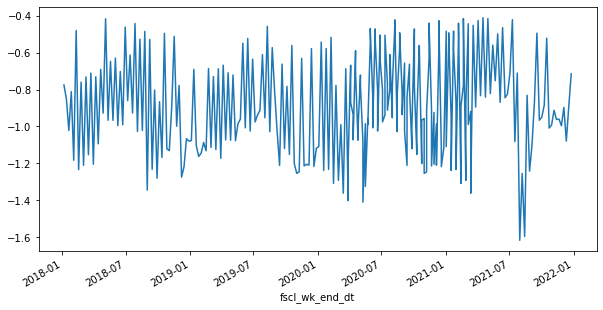

In [ ]:
final_df_2 = np.log(final_df_1['ty_div_tdp'])
final_df_2.plot(figsize=(10,5))

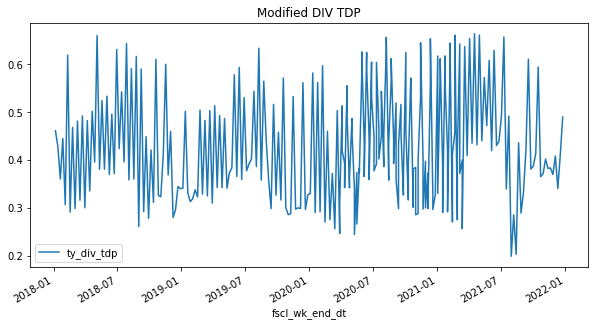

In [ ]:
final_df_1.plot(figsize=(10,5),title="Modified DIV TDP")

In [ ]:
df

,ty_div_tdp
fscl_wk_end_dt,
2018-01-06,0.460651
2018-01-13,0.427280
2018-01-20,0.359968
2018-01-27,0.444367
2018-02-03,0.306313
...,...
2021-11-27,0.369375
2021-12-04,0.407805
2021-12-11,0.339899


In [ ]:
look_back=13
mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()
df_scaled = mm_scaler.fit_transform(df)

In [ ]:
df_scaled

array([[0.5640346 ],
       [0.49225188],
       [0.3474609 ],
       [0.52900781],
       [0.23204791],
       [0.90421542],
       [0.19898601],
       [0.57936547],
       [0.21413326],
       [0.60804654],
       [0.2520438 ],
       [0.63017581],
       [0.21801119],
       [0.60948421],
       [0.29355005],
       [0.6513925 ],
       [0.4237301 ],
       [0.99209348],
       [0.39154104],
       [0.69922244],
       [0.39124711],
       [0.71960042],
       [0.36791391],
       [0.63884976],
       [0.37165601],
       [0.92951577],
       [0.48325091],
       [0.73872649],
       [0.42429797],
       [0.95610513],
       [0.3433828 ],
       [0.84327244],
       [0.34736961],
       [0.89800491],
       [0.13343667],
       [0.84151493],
       [0.20052543],
       [0.53763827],
       [0.17082668],
       [0.47790245],
       [0.24199684],
       [0.8846598 ],
       [0.27376581],
       [0.26727957],
       [0.45746361],
       [0.86283129],
       [0.36533107],
       [0.561

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
#look_back = 13
def df_to_X_y(df, window_size=look_back):
  #df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df) - window_size):
    row = [[a] for a in df[i:i+window_size]]
    #print(row)
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  
  print(np.array(X).shape)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y(df_scaled, look_back)
X1.shape, y1.shape

(195, 13, 1, 1)


((195, 13, 1, 1), (195, 1))

In [ ]:
X_train1, y_train1 = X1[:208], y1[:208]
X_val1, y_val1 = X1[208:169], y1[208:169]
X_test1, y_test1 = X1[208:], y1[169:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((156, 13, 1, 1), (156, 1), (13, 13, 1, 1), (13, 1), (26, 13, 1, 1), (26, 1))

In [ ]:
model1 = Sequential()
'''
model1.add(InputLayer((look_back, 1)))
model1.add(LSTM(64))
model1.add(Dense(32, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()
'''
# Adding 1st LSTM layer
model1.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 1)))
model1.add(Dropout(0.1))

# Adding 2nd LSTM layer
model1.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model1.add(Dropout(0.1))

# Output layer
model1.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model1.compile(optimizer = Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
cp1 = ModelCheckpoint('/content/model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=64, callbacks=[es, rlr, mcp, tb], verbose=1, batch_size=64)

Epoch 1/64
1/3 [=========>....................] - ETA: 7s - loss: 0.0666 - root_mean_squared_error: 0.2580
Epoch 00001: val_loss improved from inf to 0.05055, saving model to weights.h5
3/3 [==============================] - 4s 454ms/step - loss: 0.0646 - root_mean_squared_error: 0.2542 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2248 - lr: 1.0000e-04
Epoch 2/64
1/3 [=========>....................] - ETA: 0s - loss: 0.0666 - root_mean_squared_error: 0.2581
Epoch 00002: val_loss did not improve from 0.05055
3/3 [==============================] - 0s 29ms/step - loss: 0.0638 - root_mean_squared_error: 0.2526 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2271 - lr: 1.0000e-04
Epoch 3/64
1/3 [=========>....................] - ETA: 0s - loss: 0.0637 - root_mean_squared_error: 0.2523
Epoch 00003: val_loss did not improve from 0.05055
3/3 [==============================] - 0s 39ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.0514 - val_root_mean_squared_err

In [ ]:
# Generate list of sequence of days for predictions
n_future = 13
datelist_future = pd.date_range(df.index[-1], periods=n_future, freq='7d')[1:].tolist()

In [ ]:
train_predictions_1 = model1.predict(X_train1).flatten()
train_predictions_1 = mm_scaler.inverse_transform(train_predictions_1.reshape(-1,1))
train_results_1 = pd.DataFrame(data={'train_predictions':train_predictions_1.flatten(), 'actuals':y_train1.flatten()})
train_results_1

,train_predictions,actuals
0,0.413657,0.609484
1,0.412623,0.293550
2,0.410010,0.651393
3,0.413699,0.423730
4,0.413175,0.992093
...,...,...
151,0.478320,0.467142
152,0.482487,0.954380
153,0.491700,0.431790
154,0.486161,0.942598


In [ ]:
mse = mean_squared_error(train_results_1.train_predictions, train_results_1.actuals)
r2 = r2_score(train_results_1.train_predictions, train_results_1.actuals)
mae = mean_absolute_error(train_results_1.train_predictions, train_results_1.actuals)
mape = mean_absolute_percentage_error(train_results_1.train_predictions, train_results_1.actuals)

print('The MSE is {}'. format(mse))
print('The RMSE is {}'. format(sqrt(mse)))
#print('The R2 is {}'. format(r2))
print('The MAE is {}'. format(mae))
print('The MAPE is {}'. format(mape))

The MSE is 0.06651038694670316
The RMSE is 0.2578960778040317
The MAE is 0.20598167790089844
The MAPE is 48.17922042305932


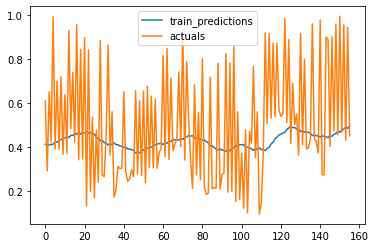

In [ ]:
train_results_1.plot()

In [ ]:
val_predictions_1 = model1.predict(X_val1).flatten()
val_predictions_1 = mm_scaler.inverse_transform(val_predictions_1.reshape(-1,1))
val_results_1 = pd.DataFrame(data={'val_predictions':val_predictions_1.flatten(), 'actuals':y_val1.flatten()})
val_results_1

,val_predictions,actuals
0,0.499658,0.978756
1,0.499354,0.508157
2,0.495104,1.000000
3,0.503360,0.501006
4,0.499072,0.993591
5,0.506279,0.518817
6,0.501453,0.803216
7,0.506301,0.586733
8,0.500654,0.880635
9,0.506062,0.475094


In [ ]:
mse = mean_squared_error(val_results_1.val_predictions, val_results_1.actuals)
r2 = r2_score(val_results_1.val_predictions, val_results_1.actuals)
mae = mean_absolute_error(val_results_1.val_predictions, val_results_1.actuals)
mape = mean_absolute_percentage_error(val_results_1.val_predictions, val_results_1.actuals)

print('The MSE is {}'. format(mse))
print('The RMSE is {}'. format(sqrt(mse)))
#print('The R2 is {}'. format(r2))
print('The MAE is {}'. format(mae))
print('The MAPE is {}'. format(mape))

The MSE is 0.08875783774235399
The RMSE is 0.297922536479458
The MAE is 0.21128354456312604
The MAPE is 42.312287682170144


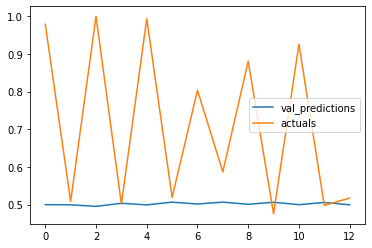

In [ ]:
val_results_1.plot()

In [ ]:
test_predictions_1 = model1.predict(X_test1).flatten()
test_predictions_1 = mm_scaler.inverse_transform(test_predictions_1.reshape(-1,1))
test_results_1 = pd.DataFrame(data={'test_predictions':test_predictions_1.flatten(), 'actuals':y_test1.flatten()})
test_results_1

,test_predictions,actuals
0,0.499017,0.630464
1,0.491432,0.985267
2,0.496358,0.302085
3,0.486680,0.630117
4,0.486514,0.000000
5,0.469801,0.186216
6,0.458773,0.008942
7,0.439038,0.510085
8,0.428209,0.194257
9,0.411091,0.289984


In [ ]:
mse = mean_squared_error(test_results_1.test_predictions, test_results_1.actuals)
r2 = r2_score(test_results_1.test_predictions, test_results_1.actuals)
mae = mean_absolute_error(test_results_1.test_predictions, test_results_1.actuals)
mape = mean_absolute_percentage_error(test_results_1.test_predictions, test_results_1.actuals)

print('The MSE is {}'. format(mse))
print('The RMSE is {}'. format(sqrt(mse)))
#print('The R2 is {}'. format(r2))
print('The MAE is {}'. format(mae))
print('The MAPE is {}'. format(mape))

The MSE is 0.05592758993301124
The RMSE is 0.2364901476446984
The MAE is 0.16636199821063397
The MAPE is 37.88356525229167


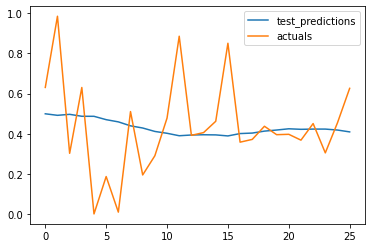

In [ ]:
test_results_1.plot()

In [ ]:
ftr_predictions_1 = model1.predict(X_test1).flatten()
ftr_predictions_1 = mm_scaler.inverse_transform(ftr_predictions_1.reshape(-1,1))
ftr_results_1 = pd.DataFrame(data={'future_predictions':ftr_predictions_1.flatten()})
ftr_results_1

,future_predictions
0,0.499017
1,0.491432
2,0.496358
3,0.486680
4,0.486514
5,0.469801
6,0.458773
7,0.439038
8,0.428209
9,0.411091


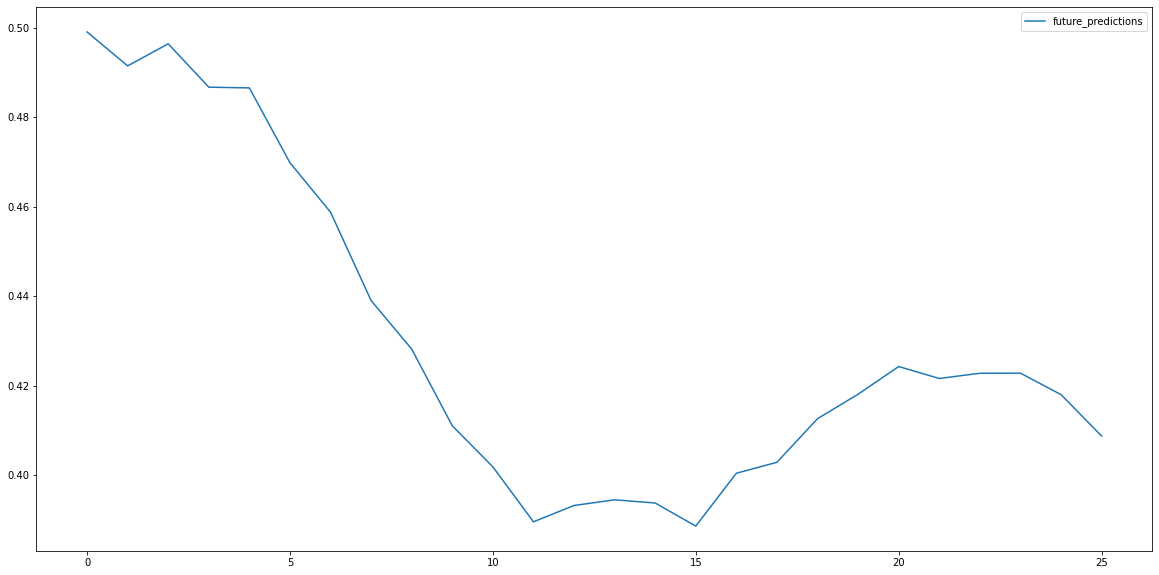

In [ ]:
ftr_results_1.plot(figsize=(20,10))

In [ ]:
orig_df[orig_df.khc_fscl_yr_wk_val <= 202052].shape, orig_df[orig_df.khc_fscl_yr_wk_val <= 201952].shape

((156, 34), (104, 34))

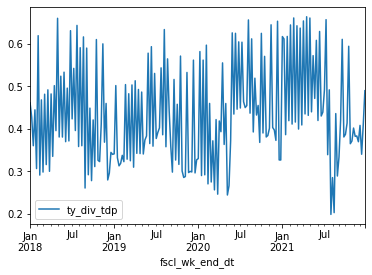

In [ ]:
df.plot()

In [ ]:
df_try_3 = orig_df[['fscl_wk_end_dt', 'khc_fscl_yr_wk_val', 'ty_div_tdp']]
df_try_3['rolling_13wk_sma_ty_div_tdp'] = df_try_3[['ty_div_tdp']].rolling(13).mean()
df_try_3['cma_13wk_ty_div_tdp'] =  df_try_3['ty_div_tdp'].expanding(min_periods=13).mean()
df_try_3['ema_13wk_no_adj_ty_div_tdp'] = df_try_3['ty_div_tdp'].ewm(span=13,adjust=False).mean()
df_try_3['ema_5wk_no_adj_ty_div_tdp'] = df_try_3['ty_div_tdp'].ewm(span=5,adjust=False).mean()
df_try_3['ema_13wk_adj_ty_div_tdp'] = df_try_3['ty_div_tdp'].ewm(span=13,adjust=True).mean()
df_try_3['ema_5wk_adj_ty_div_tdp'] = df_try_3['ty_div_tdp'].ewm(span=5,adjust=True).mean()

df_try_3 = df_try_3[['ty_div_tdp', 'rolling_13wk_sma_ty_div_tdp', 'cma_13wk_ty_div_tdp','ema_13wk_no_adj_ty_div_tdp','ema_5wk_no_adj_ty_div_tdp', 'ema_13wk_adj_ty_div_tdp', 'ema_5wk_adj_ty_div_tdp']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

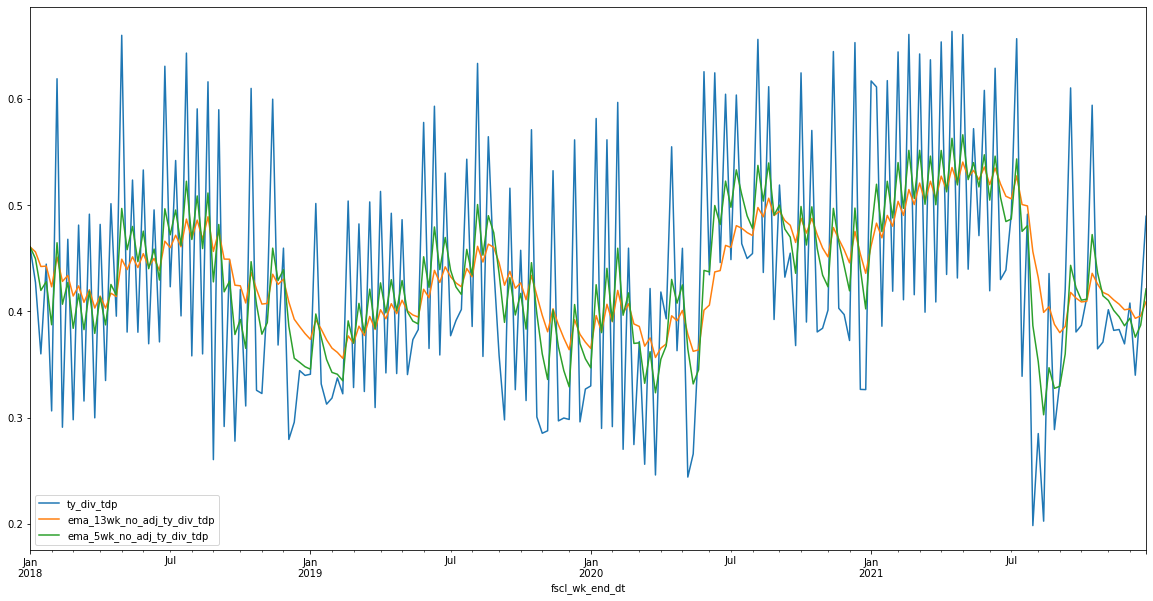

In [ ]:
col_list = ['ty_div_tdp', 'ema_13wk_no_adj_ty_div_tdp','ema_5wk_no_adj_ty_div_tdp']
df_try_3[col_list].plot(figsize=(20,10))

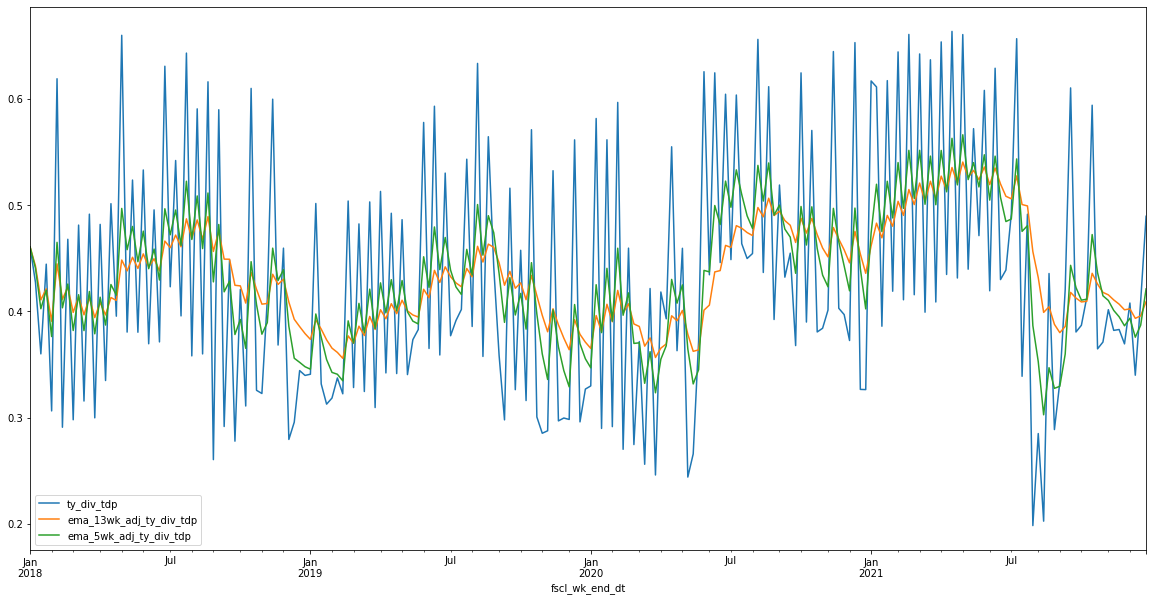

In [ ]:
col_list = ['ty_div_tdp', 'ema_13wk_adj_ty_div_tdp', 'ema_5wk_adj_ty_div_tdp']
df_try_3[col_list].plot(figsize=(20,10))

In [ ]:
df_try_3[['ty_div_tdp', 'ema_13wk_no_adj_ty_div_tdp']]

,ty_div_tdp,ema_13wk_no_adj_ty_div_tdp
fscl_wk_end_dt,,
2018-01-06,0.460651,0.460651
2018-01-13,0.427280,0.455883
2018-01-20,0.359968,0.442181
2018-01-27,0.444367,0.442493
2018-02-03,0.306313,0.423039
...,...,...
2021-11-27,0.369375,0.401412
2021-12-04,0.407805,0.402326
2021-12-11,0.339899,0.393408


In [ ]:
mse = mean_squared_error(df_try_3.ema_13wk_no_adj_ty_div_tdp, df_try_3.ty_div_tdp)
r2 = r2_score(df_try_3.ema_13wk_no_adj_ty_div_tdp, df_try_3.ty_div_tdp)
mae = mean_absolute_error(df_try_3.ema_13wk_no_adj_ty_div_tdp, df_try_3.ty_div_tdp)
mape = mean_absolute_percentage_error(df_try_3.ema_13wk_no_adj_ty_div_tdp, df_try_3.ty_div_tdp)

se_mape = abs(np.array(df_try_3.ty_div_tdp)-np.array(df_try_3.ema_13wk_no_adj_ty_div_tdp))/np.array(df_try_3.ty_div_tdp)
ft_actual_sum = np.array(df_try_3.ty_div_tdp).sum()
se_actual_prod_mape = np.array(df_try_3.ty_div_tdp) * se_mape
ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
wmape = ft_actual_prod_mape_sum / ft_actual_sum
smape = np.mean(np.abs(np.array(df_try_3.ty_div_tdp)-np.array(df_try_3.ema_13wk_no_adj_ty_div_tdp)) / (np.abs(np.array(df_try_3.ty_div_tdp)) + np.abs(np.array(df_try_3.ema_13wk_no_adj_ty_div_tdp))) /2)

print('The MSE is {}'. format(mse))
print('The RMSE is {}'. format(sqrt(mse)))
#print('The R2 is {}'. format(r2))
print('The MAE is {}'. format(mae))
print('The MAPE is {}'. format(mape))
print('The wMAPE is {}'. format(wmape))
print('The sMAPE is {}'. format(smape))

The MSE is 0.0098274567068639
The RMSE is 0.09913352968024441
The MAE is 0.08487773975790841
The MAPE is 19.45703190396016
The wMAPE is 0.1954747022274039
The sMAPE is 0.04903580662936842


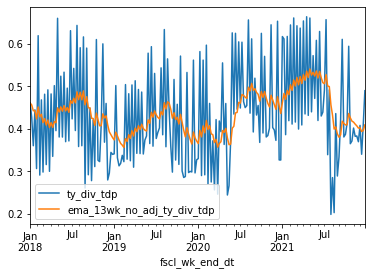

In [ ]:
df_try_3[['ty_div_tdp', 'ema_13wk_no_adj_ty_div_tdp']].plot()